In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser
pd.options.display.float_format = '{:,.0f}'.format


In [4]:
df = pd.read_csv("../Relleno/Data_ventas_diarias.csv", encoding="utf-8")
df.head()

,id_transaccion,fecha,mes,id_producto,nombre_producto,id_tienda,nombre_tienda,categoria_tienda,ciudad_normalizada,ventas_diarias,precio_normalizado
0,1,2025-10-27,10,63,Salsa Bufalo,6,City Market,Premium,CANCUN,18,23.10
1,2,2025-12-27,12,32,Agua Epura 1L,5,Chedraui,Autoservicio,PUEBLA,68,9.49
2,3,2025-11-09,11,77,Cereal Choco Krispis,2,Sam's Club,Mayoreo,PUEBLA,41,53.36
3,4,2025-10-27,10,45,Mix de Nueces Member's Mark,7,La Comer,Premium,CANCUN,13,88.14
4,5,2025-09-03,9,42,Yoghurt Griego Yoplait,1,Walmart,Autoservicio,GUADALAJARA,9,28.32


### **Ciudades con mas y menos ventas**


In [17]:
#Definimos las ventas
df["ingresos"] = df["precio_normalizado"] * df["ventas_diarias"]

#Las agrupamos por ciudad
ventas_ciudad = (
    df.groupby("ciudad_normalizada")["ingresos"]
      .sum()
      .sort_values(ascending=False)
)
#Sacamos en porcentaje para ver que total representa cada ciudad
ventas_ciudad_pct = (ventas_ciudad / ventas_ciudad.sum()) * 100

ventas_ciudad

ciudad_normalizada
PUEBLA        237,636,584
CDMX          237,313,904
MONTERREY     236,210,486
CANCUN        236,110,953
GUADALAJARA   235,838,272
Name: ingresos, dtype: float64

In [19]:
tabla_ciudades = ventas_ciudad_pct.reset_index(name="porcentaje_ventas")

tabla_ciudades = tabla_ciudades.rename(columns={
    "ciudad_normalizada": "ciudad"
})

tabla_ciudades["porcentaje_ventas"] = (
    tabla_ciudades["porcentaje_ventas"]
    .map(lambda x: f"{x:.2f}%")
)

tabla_ciudades


,ciudad,porcentaje_ventas
0,PUEBLA,20.09%
1,CDMX,20.06%
2,MONTERREY,19.97%
3,CANCUN,19.96%
4,GUADALAJARA,19.93%


### **Tiendas con mas y menos ganancias**

In [22]:
#Primero sacamos las ganancias totales de cada tienda de manera anual
ganancias_tienda = (
    df.groupby("nombre_tienda")["ingresos"]
      .sum()
      .sort_values(ascending=False)
)
#Ahora sacamos su promedio diario por tienda
promedio_diario_tienda = (
    df.groupby("nombre_tienda")
      .agg(
          ingresos_totales=("ingresos", "sum"),
          dias_activos=("fecha", "nunique")
      )
      .assign(promedio_diario=lambda x: x["ingresos_totales"] / x["dias_activos"])
      ["promedio_diario"]
)



In [24]:
tabla_tiendas = (
    pd.DataFrame({
        "ganancias_totales": ganancias_tienda,
        "promedio_diario": promedio_diario_tienda
    })
    .sort_values("ganancias_totales", ascending=False)
    .reset_index()
)

tabla_tiendas

,nombre_tienda,ganancias_totales,promedio_diario
0,City Market,"119,711,851","327,978"
1,Bodega Aurrera,"119,174,486","326,505"
2,La Comer,"118,879,563","325,697"
3,Sam's Club,"118,796,189","325,469"
4,Oxxo,"118,702,848","325,213"
5,Costco,"118,051,380","323,428"
6,Tienda 3B,"117,918,991","323,066"
7,Chedraui,"117,805,218","322,754"
8,Walmart,"117,090,554","320,796"
9,Soriana,"116,979,120","320,491"


# Ahora vamos a analizar las desviaciones estandar en las ventas
Recordemos que mientras mas alta sea la desviacion estandar mas variante e impredecible es el producto/tienda, y si tiene una desviacion mas baja significa que es mas ajustada al promedio por lo que es mas estable.
En el caso de las tiendas representa una desviacion mayor que la tienda tiene una consistencia de desempeño diario irregular
En el caso de los productos una alta desviacion representa una demanda irregular

In [25]:
#Analizamos primero la desviacion de las ventas diarias
std_ventas_general = df["ventas_diarias"].std()
std_ventas_general


np.float64(26.445963635843043)

In [30]:
#Ahora por tienda
std_ventas_tienda = (
    df.groupby("nombre_tienda")["ventas_diarias"]
      .std()
      .sort_values(ascending=False)
)
tabla_std_tienda.style.format({"desviacion_std_ventas": "{:.2f}"})


,nombre_tienda,desviacion_std_ventas
0,Costco,26.55
1,Chedraui,26.50
2,Sam's Club,26.49
3,Tienda 3B,26.46
4,La Comer,26.45
5,Walmart,26.45
6,Bodega Aurrera,26.41
7,Soriana,26.39
8,City Market,26.38
9,Oxxo,26.37


In [28]:
std_ventas_producto = (
    df.groupby("nombre_producto")["ventas_diarias"]
      .std()
      .sort_values(ascending=False)
)
std_ventas_producto

nombre_producto
Refresco Fanta 600ml   29
Pan Integral Bimbo     29
Pan Tostado Bimbo      29
Agua Bonafont 1L       29
Pan Bimbo Blanco       29
                       ..
Choco Milk              8
Monster Energy          8
Jamón de Pavo FUD       8
Powerade Moras 500ml    8
Cacahuates Hot Nuts     8
Name: ventas_diarias, Length: 100, dtype: float64

### Ahora veremos la comparativa de las ventas mes por mes

import numpy as np
import matplotlib.pyplot as plt

# Lista de tiendas
tiendas = ventas_mensuales_tienda["nombre_tienda"].unique()

# Configuración del mosaico
n_cols = 5
n_rows = int(np.ceil(len(tiendas) / n_cols))

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(15, 6),
    sharex=True,
    sharey=True
)

axes = axes.flatten()

# Graficar cada tienda
for i, tienda in enumerate(tiendas):
    data_tienda = ventas_mensuales_tienda[
        ventas_mensuales_tienda["nombre_tienda"] == tienda
    ]

    # Línea de evolución
    axes[i].plot(
        data_tienda["mes"],
        data_tienda["ingresos"],
        marker="o"
    )

    # Máximo
    idx_max = data_tienda["ingresos"].idxmax()
    mes_max = data_tienda.loc[idx_max, "mes"]
    ingreso_max = data_tienda.loc[idx_max, "ingresos"]

    axes[i].scatter(mes_max, ingreso_max)
    axes[i].annotate(
        f"Max: Mes {mes_max}",
        (mes_max, ingreso_max),
        textcoords="offset points",
        xytext=(5, 5),
        fontsize=8
    )

    # Mínimo
    idx_min = data_tienda["ingresos"].idxmin()
    mes_min = data_tienda.loc[idx_min, "mes"]
    ingreso_min = data_tienda.loc[idx_min, "ingresos"]

    axes[i].scatter(mes_min, ingreso_min)
    axes[i].annotate(
        f"Min: Mes {mes_min}",
        (mes_min, ingreso_min),
        textcoords="offset points",
        xytext=(5, -10),
        fontsize=8
    )

    axes[i].set_title(tienda, fontsize=9)
    axes[i].grid(alpha=0.3)

# Eliminar subplots vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle(
    "Evolución mensual de ventas por tienda (picos y caídas resaltados)",
    fontsize=14
)
fig.supxlabel("Mes")
fig.supylabel("Ingresos")

plt.tight_layout()
plt.show()


**Correlacion entre tiendas**

In [76]:
ventas_mensuales_tienda = (
    df.groupby(["nombre_tienda", "mes"])["ingresos"]
      .sum()
      .reset_index()
)
tabla_corr = ventas_mensuales_tienda.pivot(
    index="mes",
    columns="nombre_tienda",
    values="ingresos"
)
corr_tiendas = tabla_corr.corr()




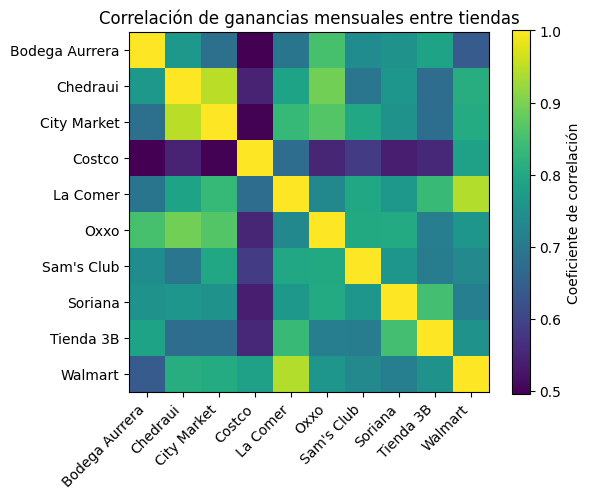

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))

plt.imshow(corr_tiendas)
plt.colorbar(label="Coeficiente de correlación")

plt.xticks(
    range(len(corr_tiendas.columns)),
    corr_tiendas.columns,
    rotation=45,
    ha="right"
)
plt.yticks(
    range(len(corr_tiendas.index)),
    corr_tiendas.index
)

plt.title("Correlación de ganancias mensuales entre tiendas")

plt.tight_layout()
plt.show()


## **Analisis Por Productos**

**Productos mas y menos vendidos**

In [51]:
#Primero sacamos las ventas totales por producto
ventas_producto = (
    df.groupby("nombre_producto")["ventas_diarias"]
      .sum()
      .sort_values(ascending=False)
)
#Ahora sacamos los productos mas vendidos 
print ("productos mas vendidos",ventas_producto.head(10))

#y los menos vendidos
print ("\n\nproductos menos vendidos",ventas_producto.tail(10))

productos mas vendidos nombre_producto
Huevo San Juan 18p          702528
Pan de Caja Wonder          701385
Tortillas Tía Rosa          697459
Agua Ciel 1L                696925
Pan Tostado Bimbo           696230
Agua Bonafont 1L            694948
Azúcar Zulka 1kg            694205
Agua Mineral Topo Chico     693224
Tortillas de Maíz Maseca    690037
Leche Deslactosada Lala     689465
Name: ventas_diarias, dtype: int64


productos menos vendidos nombre_producto
Refresco Fresca 600ml              153776
Vino Tinto Casillero del Diablo    147135
Cerveza Heineken                   144941
Cerveza Corona 355ml               143918
Cerveza Victoria                   143681
Mezcal 400 Conejos                 143604
Cerveza Modelo Especial            143552
Tequila José Cuervo Tradicional    142360
Cerveza Stella Artois              142250
Ron Bacardí Blanco                 140560
Name: ventas_diarias, dtype: int64


**Productos con mas ganancias**

In [55]:
#Sacamos primero las ganancias
df["ingresos"] = df["precio_normalizado"] * df["ventas_diarias"]

#Ahora sacamos las ganancias totales por producto
ganancia_producto = (
    df.groupby("nombre_producto")["ingresos"]
      .sum()
      .sort_values(ascending=False)
)
#Ahora sacamos los productos con mas ganancias
print ("productos con mas ganancias",ganancia_producto.head(10))

#y los menos vendidos
print ("\n\nproductos con menos ganancias",ganancia_producto.tail(10))

productos con mas ganancias nombre_producto
Mezcal 400 Conejos                57,425,894
Tequila José Cuervo Tradicional   44,835,519
Huevo San Juan 18p                43,935,401
Queso Panela Lala                 42,704,589
Detergente Ariel 1kg              41,390,167
Ron Bacardí Blanco                35,134,739
Vino Tinto Casillero del Diablo   31,643,912
Pan Integral Bimbo                28,953,665
Papel Higiénico Pétalo            27,603,172
Pan Bimbo Blanco                  26,477,478
Name: ingresos, dtype: float64


productos con menos ganancias nombre_producto
Churrumais                2,895,193
Cerveza Corona 355ml      2,878,670
Choco Milk                2,834,477
Cerveza Modelo Especial   2,728,937
Cerveza Victoria          2,588,525
Refresco Manzanita Sol    2,578,562
Pingüinos Marinela        2,540,859
Refresco Fresca 600ml     2,539,133
Gansito Marinela          2,400,036
Sal La Fina               1,560,664
Name: ingresos, dtype: float64


**Analisis de la estacionalidad**

In [61]:
top_productos = (
    df.groupby("nombre_producto")["ingresos"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .index
)
ventas_mensuales_producto = (
    df[df["nombre_producto"].isin(top_productos)]
    .groupby(["nombre_producto", "mes"])["ingresos"]
    .sum()
    .reset_index()
)


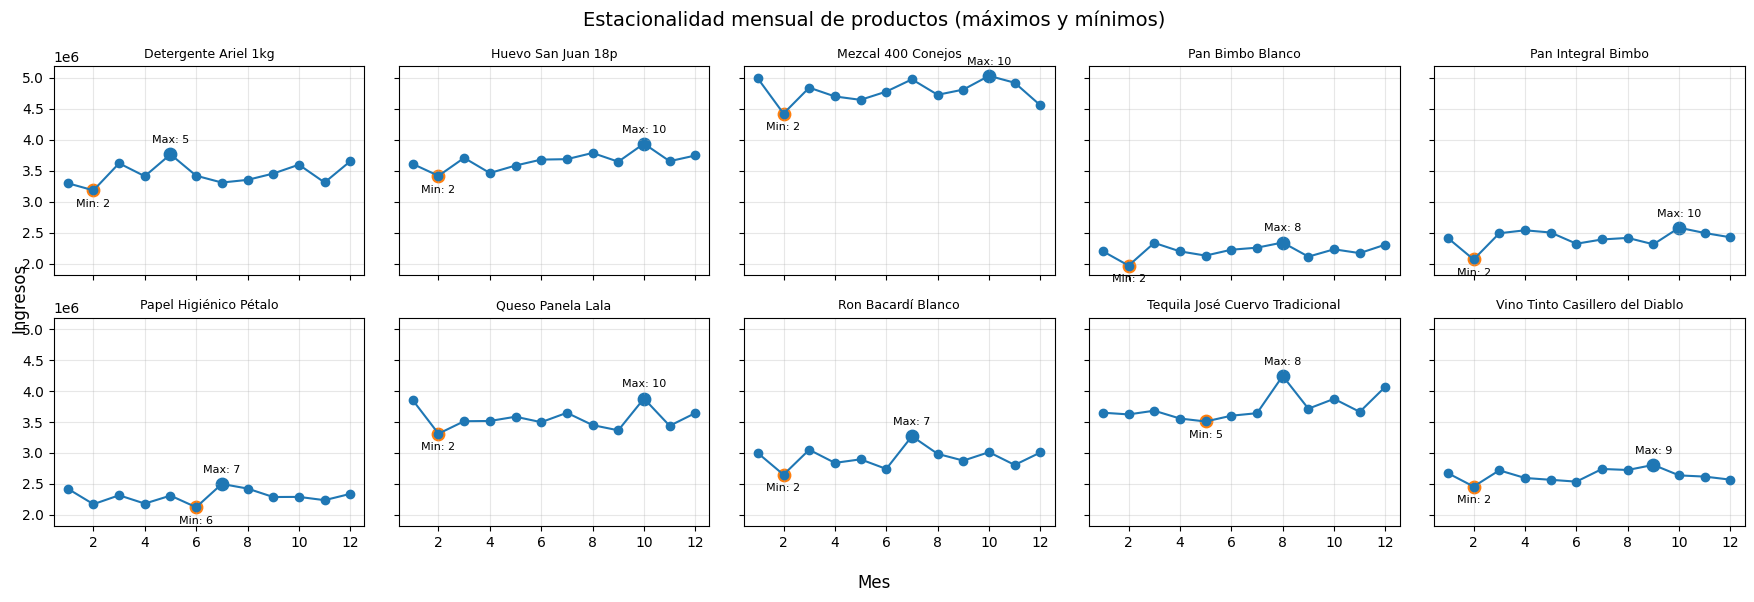

In [63]:
import numpy as np
import matplotlib.pyplot as plt

productos = ventas_mensuales_producto["nombre_producto"].unique()

n_cols = 5
n_rows = 2

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(18, 6),
    sharex=True,
    sharey=True
)

axes = axes.flatten()

for i, producto in enumerate(productos):
    data_prod = ventas_mensuales_producto[
        ventas_mensuales_producto["nombre_producto"] == producto
    ]

    # Gráfica principal
    axes[i].plot(
        data_prod["mes"],
        data_prod["ingresos"],
        marker="o"
    )

    # Mes con máximo y mínimo
    idx_max = data_prod["ingresos"].idxmax()
    idx_min = data_prod["ingresos"].idxmin()

    max_row = data_prod.loc[idx_max]
    min_row = data_prod.loc[idx_min]

    # Punto máximo
    axes[i].scatter(
        max_row["mes"],
        max_row["ingresos"],
        s=80
    )

    # Punto mínimo
    axes[i].scatter(
        min_row["mes"],
        min_row["ingresos"],
        s=80
    )

    # Anotaciones
    axes[i].annotate(
        f"Max: {max_row['mes']}",
        (max_row["mes"], max_row["ingresos"]),
        xytext=(0, 8),
        textcoords="offset points",
        ha="center",
        fontsize=8
    )

    axes[i].annotate(
        f"Min: {min_row['mes']}",
        (min_row["mes"], min_row["ingresos"]),
        xytext=(0, -12),
        textcoords="offset points",
        ha="center",
        fontsize=8
    )

    axes[i].set_title(producto, fontsize=9)
    axes[i].grid(alpha=0.3)

# Eliminar subplots vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle(
    "Estacionalidad mensual de productos (máximos y mínimos)",
    fontsize=14
)
fig.supxlabel("Mes")
fig.supylabel("Ingresos")

plt.tight_layout()
plt.show()


**Comparativas entre productos**

In [72]:
ganancia_anual_producto = (
    df.groupby("nombre_producto")["ingresos"]
      .sum()
)

# Top 10 mayores
top_10 = ganancia_anual_producto.sort_values(ascending=False).head(10)

# Bottom 20 menores
bottom_20 = ganancia_anual_producto.sort_values().head(20)

# Unir: primero top, luego bottom
extremos = pd.concat([top_10, bottom_20])


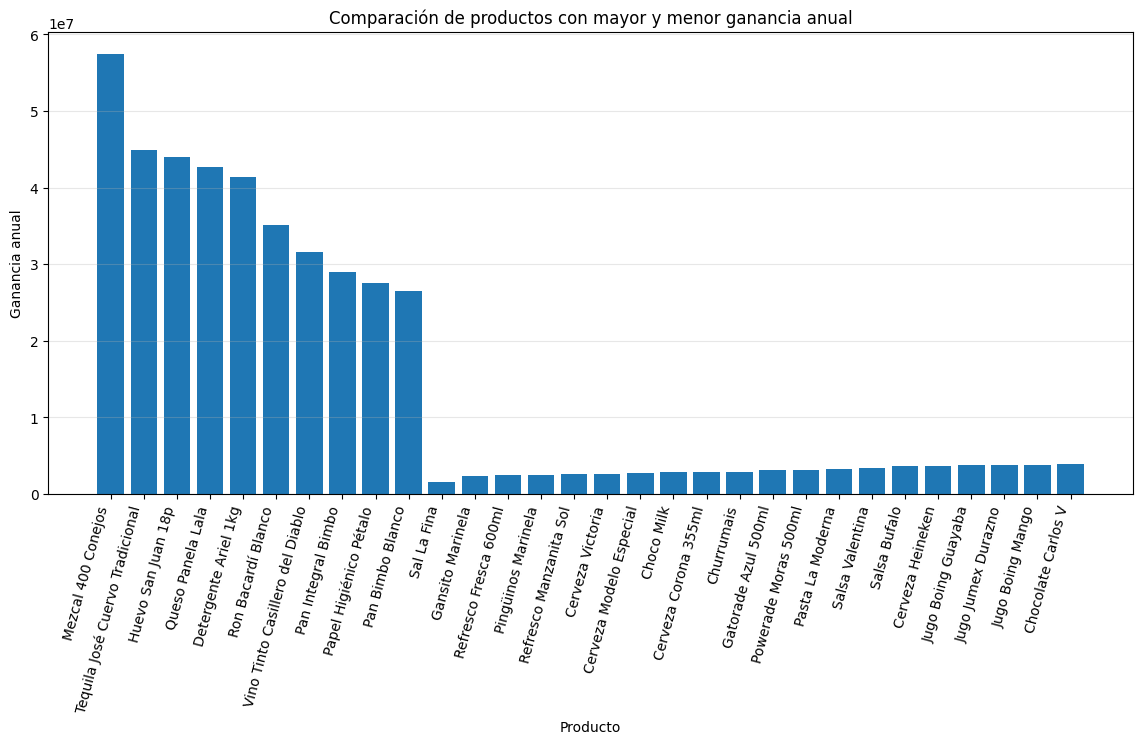

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.bar(
    extremos.index,
    extremos.values
)

plt.title("Comparación de productos con mayor y menor ganancia anual")
plt.xlabel("Producto")
plt.ylabel("Ganancia anual")
plt.xticks(rotation=75, ha="right")
plt.grid(axis="y", alpha=0.3)

plt.show()
